In [137]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))

source("src/paths/paths.R")
source("notebooks/integrazioni_regionali/nb_tools/pairing_procedure.R")

library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
library(tibble, warn.conflicts = FALSE)
library(tidyr, warn.conflicts = FALSE)
library(units, warn.conflicts = FALSE)
library(stars, warn.conflicts = FALSE)
dem <- read_stars("temp/dem/dem30.tif")

start_date <- as.Date("2000-01-01")
stop_date <- as.Date("2022-12-31")


In [178]:
path.sinottica <- file.path(path.ds, "NOAA_GHCND")
database.sinottica <- open_csv_dataset(path.sinottica,
    factory_options = list(selector_ignore_prefixes = "ghcnd")
) |>
    rename(identifier = STATION, anagrafica = NAME, lat = LATITUDE, lon = LONGITUDE, elevation = ELEVATION, date = DATE) |>
    collect()
data.sinottica <- select(database.sinottica, date, identifier, starts_with("T")) |> mutate(
    across(ends_with("ATTRIBUTES"), ~ str_split_fixed(., ",", 3) |>
        as_tibble() |>
        select(V2, V3) |>
        rename(QUALITY_FLAG = V2, SOURCE_FLAG = V3))
)
# Metadata were checked and found to be unique wrt the identifier-lon-lat-elevation tuple. These never change in station history, apparently.
metadata.sinottica <- select(database.sinottica, identifier, anagrafica, lon, lat, elevation)


In [179]:
data.values <- data.sinottica |>
    select(date, identifier, TMIN, TMAX) |>
    pivot_longer(c(TMIN, TMAX)) |>
    mutate(variable = as.factor(name), value = as.double(value), .keep = "unused")
data.flags <- data.sinottica |>
    select(date, identifier, ends_with("ATTRIBUTES")) |>
    pivot_longer(ends_with("ATTRIBUTES"), names_pattern = "(TMAX|TMIN)_ATTRIBUTES", names_to = "variable") |>
    unnest(value) |>
    mutate(variable = as.factor(variable), across(ends_with("FLAG"), ~ as.factor(.)))
data.sinottica <- full_join(data.values, data.flags, by = c("variable", "identifier", "date"), relationship = "one-to-one") |>
    left_join(data.sinottica |> select(!starts_with("T")), by = c("identifier", "date"), relationship = "many-to-one") |>
    mutate(
        variable = fct_recode(variable, T_MIN = "TMIN", T_MAX = "TMAX"),
        value = if_else(QUALITY_FLAG == "", value, NA),
        value = as_units(value, "fahrenheit") |> set_units("celsius") |> drop_units()
    )
# data |> select(!c(starts_with("T")))
# distinct(ends_with("SF"), )


In [180]:
data.sinottica |> slice_head(n = 5)


date,identifier,value,variable,QUALITY_FLAG,SOURCE_FLAG
<date>,<chr>,<dbl>,<fct>,<fct>,<fct>
2000-01-01,ITE00115588,-3.888889,T_MIN,,E
2000-01-01,ITE00115588,7.222222,T_MAX,,E
2000-01-02,ITE00115588,-2.777778,T_MIN,,E
2000-01-02,ITE00115588,7.777778,T_MAX,,E
2000-01-03,ITE00115588,-2.777778,T_MIN,,E


In [181]:
write_arpa_for_merge(data.sinottica |> select(date, identifier, value, variable) |> mutate(variable = as.character(variable)), "Sinottica")


In [185]:
metadata.sinottica |>
    distinct() |>
    write_feather(file.path("db", "metadata", "Sinottica.arrow"))


In [194]:
data.sinottica |>
    as_tsibble(index = date, key = c(variable, identifier)) |>
    filter(start_date <= date, date <= stop_date) |>
    select(!ends_with("FLAG")) |>
    fill_gaps(.full = TRUE, .start = start_date, .end = stop_date) |>
    n_available_series(start_date, stop_date)


[1] 39

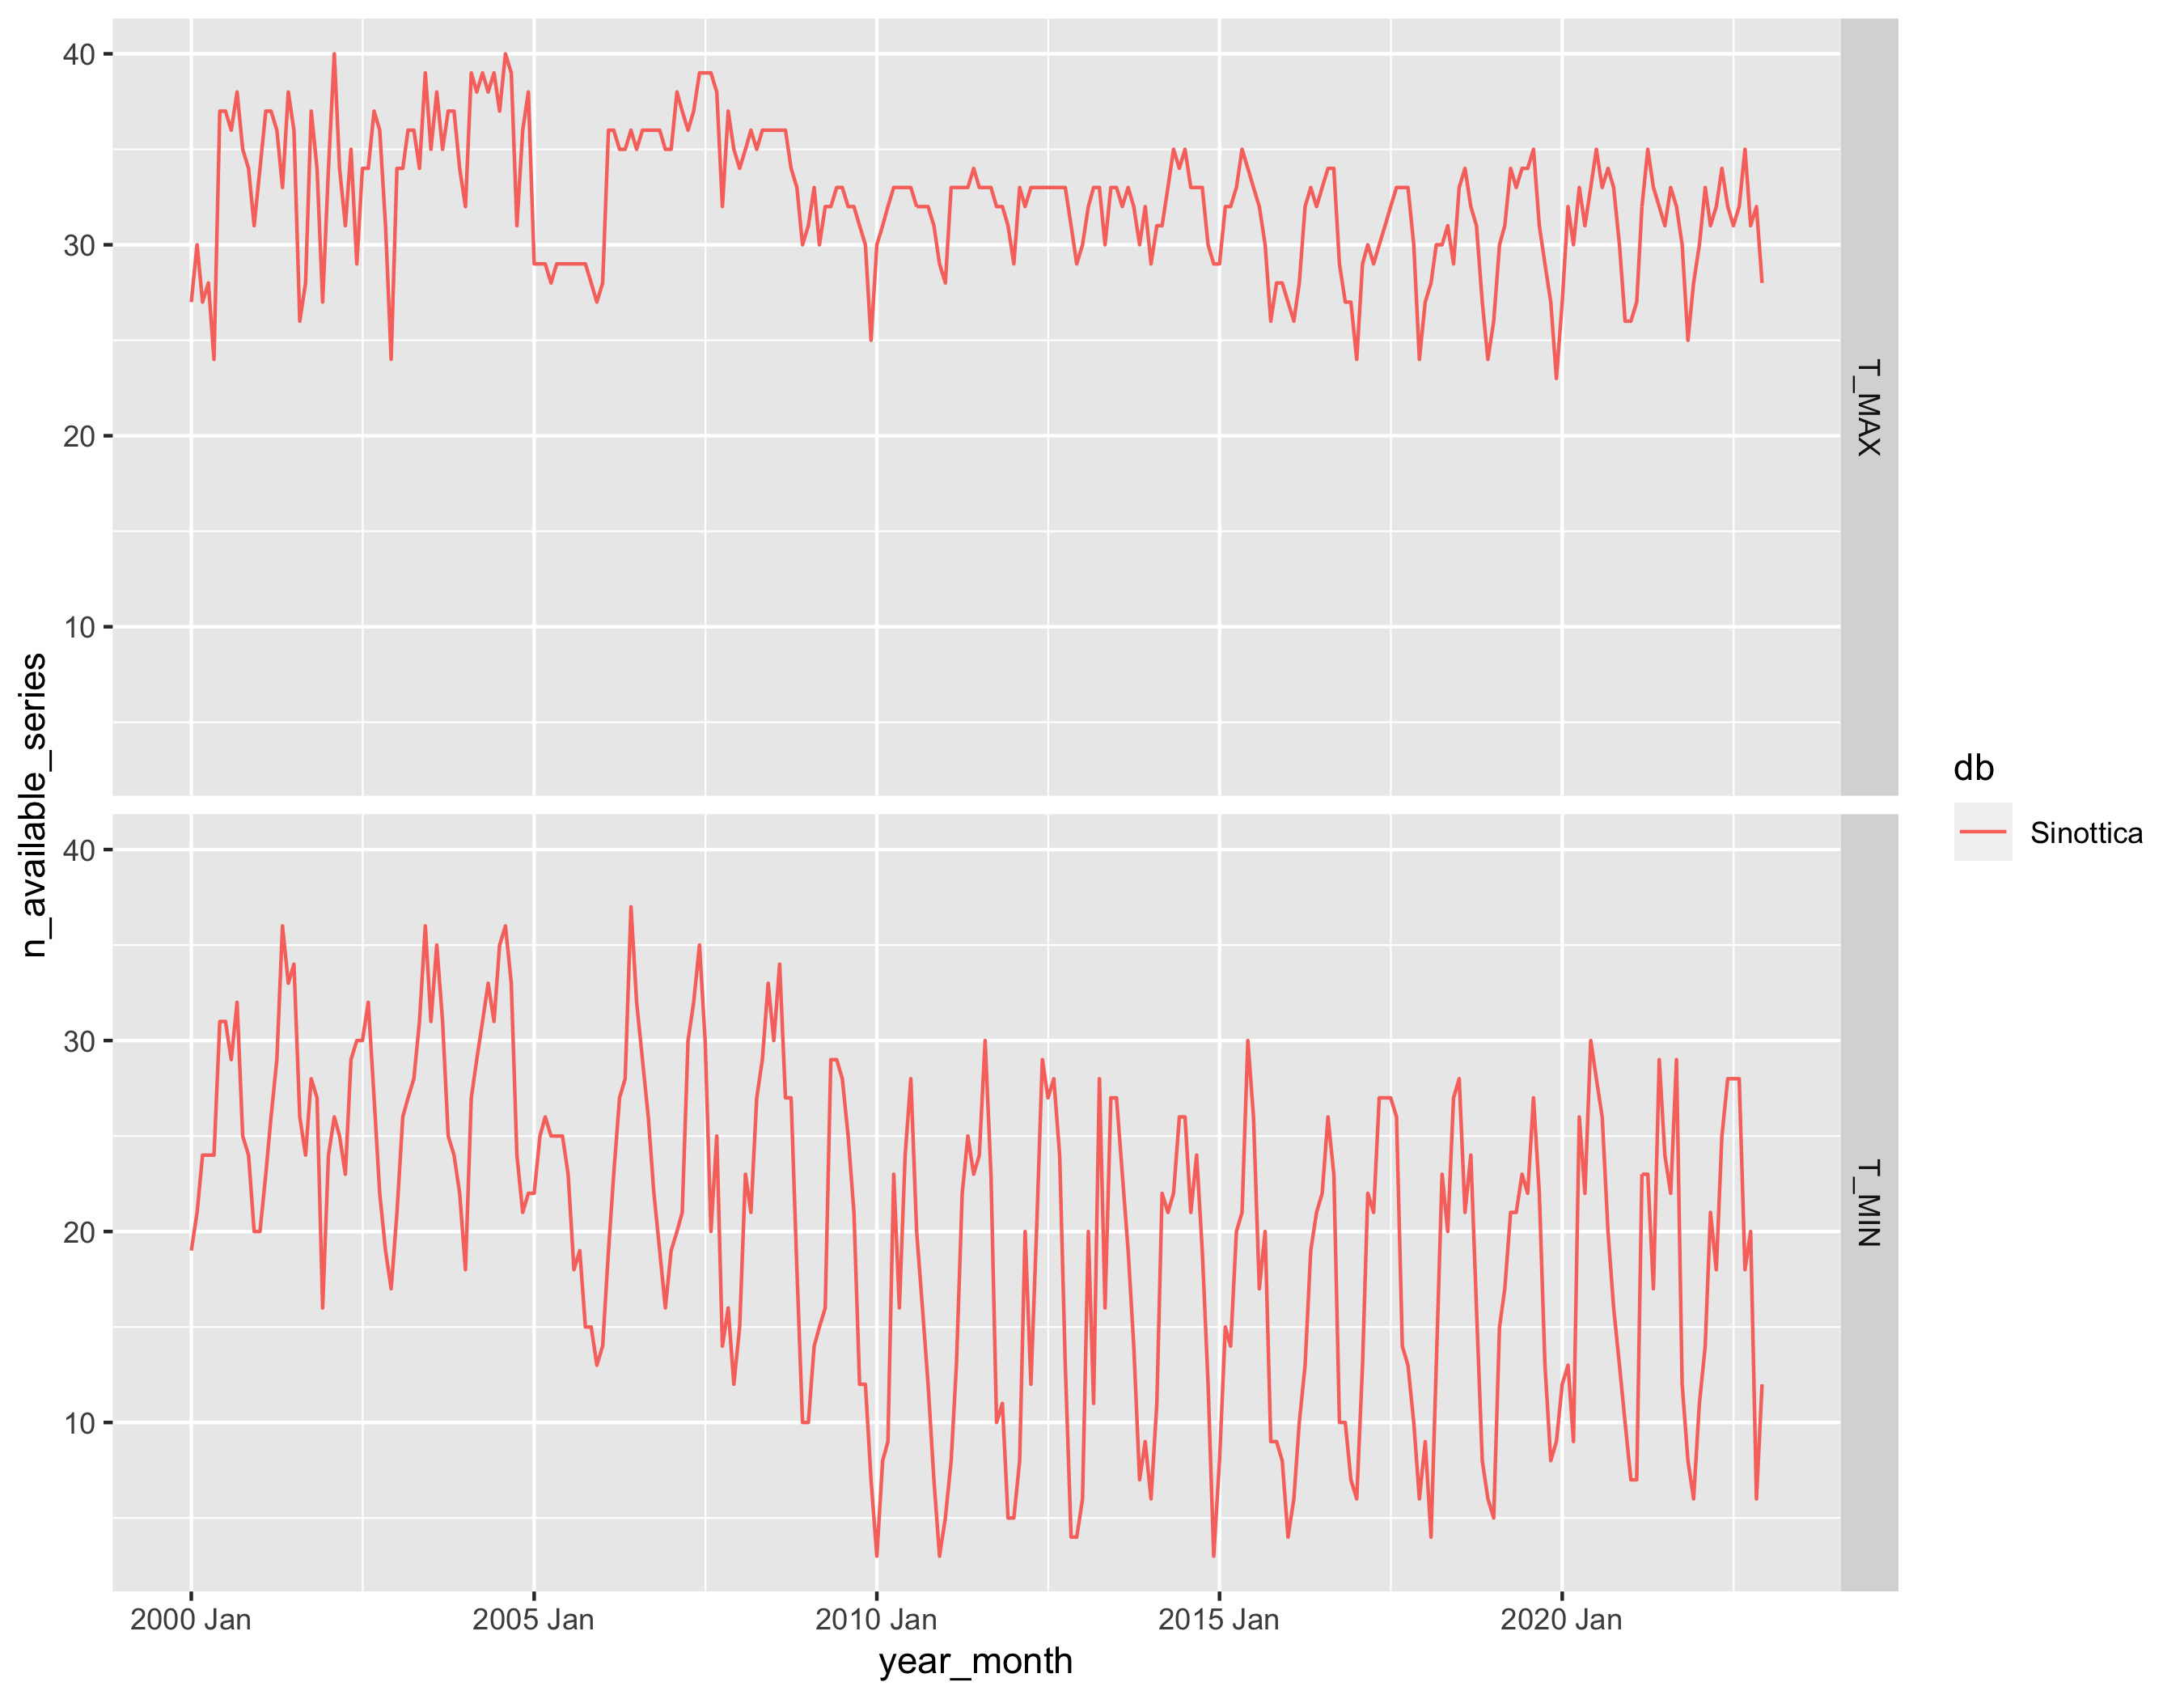

In [199]:
plot_state_avail(
    data.sinottica |> as_tsibble(index = date, key = c(variable, identifier)) |>
        filter(start_date <= date, date <= stop_date) |>
        select(!ends_with("FLAG")) |>
        fill_gaps(.full = TRUE, .start = start_date, .end = stop_date) |> mutate(db = "Sinottica")
)


In [262]:
source("src/load/load.R")
source("src/pairing/matching.R")
source("src/pairing/displaying.R")
source("src/analysis/metadata.R")
md.ds <- open.dataset("SCIA", "metadata") |>
    filter(rete == "Sinottica", last_date > "2010-01-01", lat >= 43)
md <- md.ds |>
    collect() |>
    select(!c(valid_days, ends_with("date"))) |>
    mutate(identifier = as.character(identifier))
d <- open.dataset("SCIA", "data") |>
    semi_join(md.ds, by = c("variable", "identifier")) |>
    collect() |>
    mutate(identifier = as.character(identifier)) |>
    as_tsibble(key = c(variable, identifier), index = date) |>
    fill_gaps(.full = TRUE, .start = start_date, .end = stop_date) |>
    as_tibble()
fracs <- d |>
    arrange(variable, identifier, date) |>
    group_by(variable, identifier) |>
    summarise(f0 = mean(value == 0, na.rm = TRUE), .groups = "drop") |>
    filter(f0 < 0.01)
md <- md |>
    semi_join(fracs, by = c("variable", "identifier")) |>
    build_date_stats(d, start_date, stop_date) |>
    st_md_to_sf()
# singular_availabilities <- is_climatology_computable.metadata(md, d ) |>
#     group_by(identifier, .add = TRUE) |>
#     filter(all(clim_available)) |>
#     distinct(variable, identifier)
matches <- matches_table(md, md, 10) |>
    filter(valid_days.x >= valid_days.y, identifier.x != identifier.y) |>
    arrange(variable, anagrafica.x)
# Vanno già bene? Fare calcolo disponibilità dati
singles <- md |>
    anti_join(matches, join_by(variable, identifier == identifier.x)) |>
    anti_join(matches, join_by(variable, identifier == identifier.y))


In [280]:
usable_stations <- singles |>
    is_climatology_computable.metadata(d |> as_tsibble(key = c(variable, identifier), index = date)) |>
    as_tibble() |>
    group_by(variable, identifier) |>
    summarise(all = all(clim_available), .groups = "drop") |>
    filter(all) |>
    select(variable, identifier) |>
    as_arrow_table() |>
    mutate(identifier = cast(identifier, uint32())) |>
    compute()


In [282]:
data <- open.dataset("SCIA", "data") |> semi_join(usable_stations, by = c("variable", "identifier"))
write_arpa_for_merge(data, "Sinottica") 


In [288]:
md.ds |> semi_join(usable_stations, by = c("variable", "identifier")) |> write_feather(file.path("db", "metadata", "Sinottica.arrow"))

In [ ]:
s <- read.series.single("SCIA", "T_MIN", "6690") |>
    filter(date >= "2000-01-01") |>
    setNames(c("value", "date"))
ggplot(s, aes(date, value)) +
    geom_line()


In [264]:
source("src/pairing/matching.R")
source("src/pairing/combining.R")
library(zeallot, warn.conflicts = FALSE)
c(multiple.tmin.x, multiple.tmax.x) %<-% (open.dataset("SCIA", "data") |> widen_split_data(matches, identifier.x, start_date, stop_date))
c(multiple.tmin.y, multiple.tmax.y) %<-% (open.dataset("SCIA", "data") |> widen_split_data(matches, identifier.y, start_date, stop_date))


In [265]:
source("src/pairing/analysis.R")

analysis <- build_analysis(matches |> select(!starts_with("valid")), multiple.tmin.x, multiple.tmax.x, multiple.tmin.y, multiple.tmax.y)


In [266]:
analysis |>
    filter(all_filter) |>
    meaningful_columns(identifier.y)


variable,identifier.x,anagrafica.x,anagrafica.y,distance,f0,delH,delZ,delT,maeT,sdT,corT,monthlyslopeT,monthlydelT,monthlysdT,minilap,valid_days_union,valid_days_inters,identifier.y
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>


In [189]:
s1 |>
    as_tibble() |>
    summarise(mean(T_MIN == 0, na.rm = TRUE))


"mean(T_MIN == 0, na.rm = TRUE)"
<dbl>
0.008497552


Warning message:
"Removed 580 rows containing missing values (`geom_line()`)."


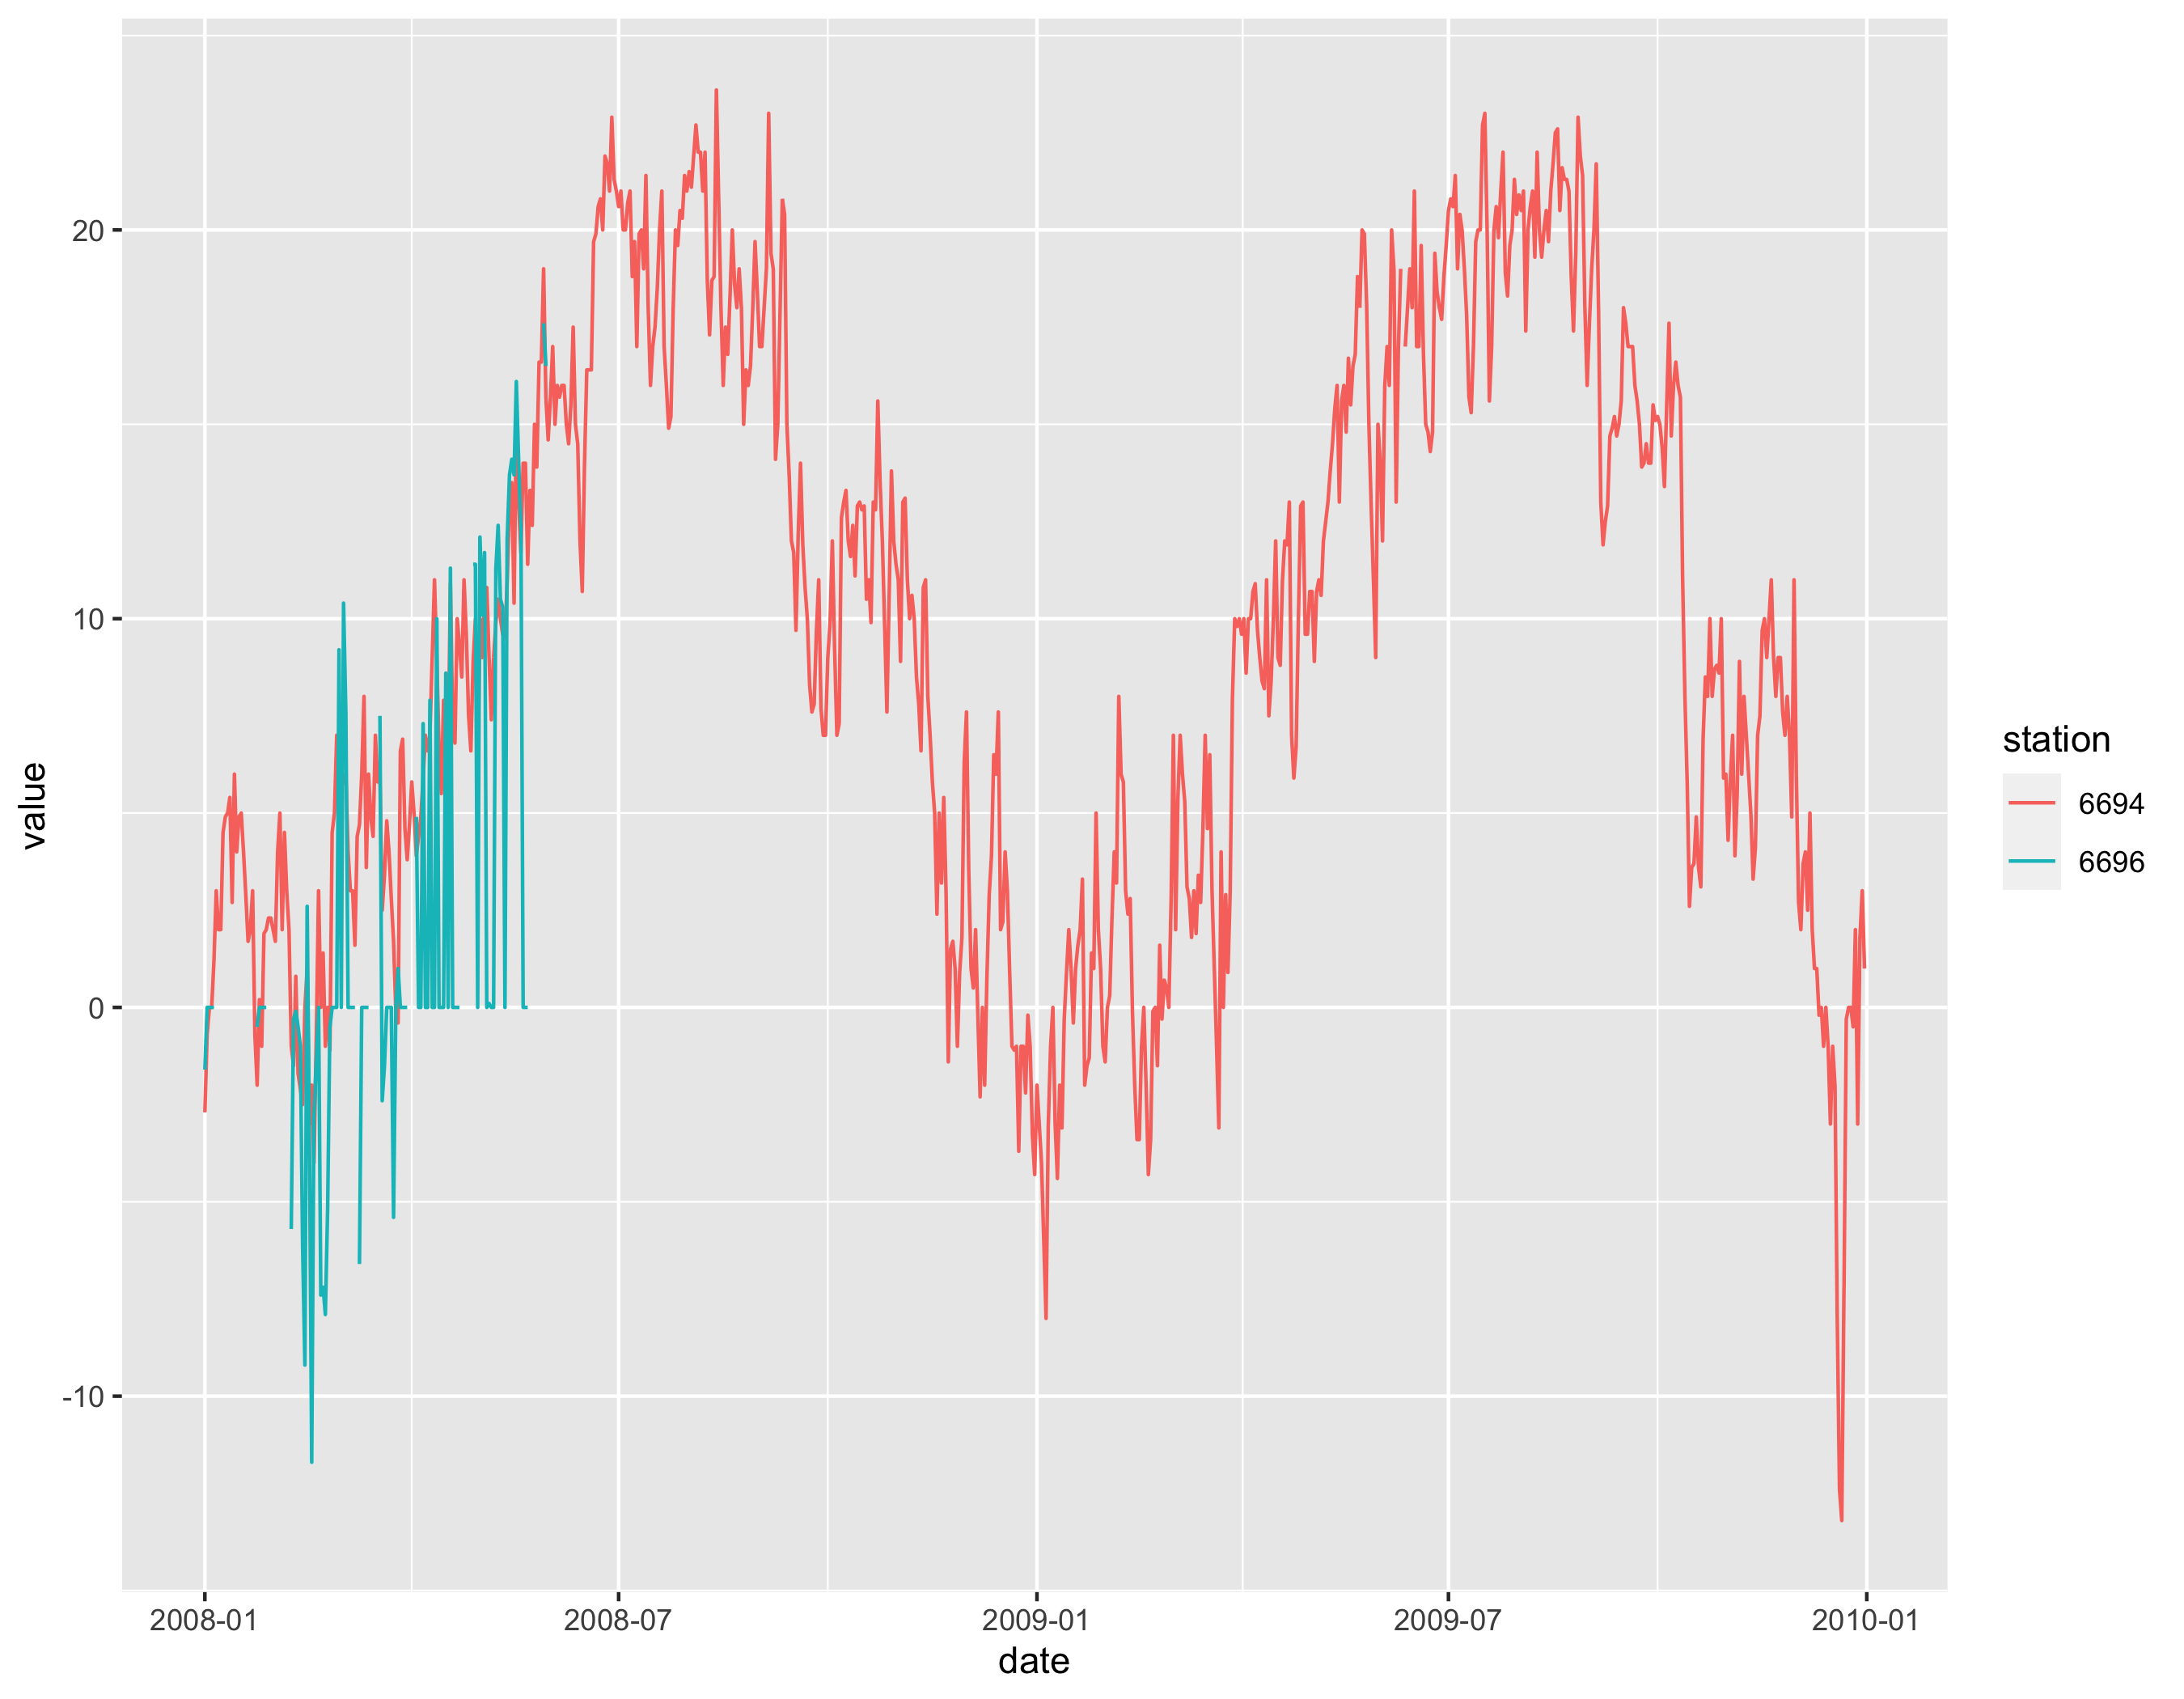

In [260]:
bind_rows(
    `6694` = read.series.single("SCIA", "T_MIN", "6763") |> setNames(c("value", "date")) |> as_tibble(),
    `6696` = read.series.single("SCIA", "T_MIN", "6756") |> setNames(c("value", "date")) |> as_tibble(),
    .id = "station"
) |>
    as_tsibble(key = station, index = date) |>
    fill_gaps(.full = TRUE) |>
    filter(2008L <= year(date), year(date) < 2010L) |>
    arrange(station, date) |>
    fill_gaps() |>
    ggplot(aes(date, value, color = station)) +
    geom_line()


In [167]:
a |>
    filter(all_filter) |>
    meaningful_columns(identifier.y, all_filter, ends_with("date.x"), ends_with("date.y"), -maeT, -delZ, -minilap) |>
    arrange(abs(monthlydelT)) |>
    filter(abs(monthlydelT) > 0.5)


variable,identifier.x,anagrafica.x,anagrafica.y,distance,f0,delH,delT,sdT,corT,...,monthlydelT,monthlysdT,valid_days_union,valid_days_inters,identifier.y,all_filter,first_date.x,last_date.x,first_date.y,last_date.y
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<int>,<int>,<chr>,<lgl>,<date>,<date>,<date>,<date>
T_MIN,6907,CAPO CACCIA,CAPO CACCIA,0.000,0.020000000,1,0.8010000,0.6363557,0.9857035,...,-0.5172864,1.5634094,8039,100,6908,TRUE,2000-01-01,2022-12-31,2005-07-27,2005-11-15
T_MIN,6867,CROTONE,CROTONE,1382.702,0.039316239,6,-0.4943590,0.8776246,0.9925298,...,-0.5197266,1.0464204,7605,585,6868,TRUE,2000-01-01,2022-12-31,2005-07-27,2012-05-31
T_MAX,6891,CATANIA/SIGONELLA,SIGONELLA,0.000,0.218124341,9,0.6367229,1.0160780,0.9868816,...,0.5239444,1.3640517,8056,1898,6892,TRUE,2000-01-01,2022-12-31,2000-01-01,2014-12-31
T_MIN,6863,BONIFATI,BONIFATI,1456.807,0.050847458,0,0.2567797,1.2698663,0.9742928,...,0.5307113,2.0987426,7438,118,6862,TRUE,2000-01-02,2022-12-31,2007-01-17,2012-05-31
T_MAX,6839,BARI/PALESE MACCHIE,BARI PALESE,1340.070,0.006825939,3,1.2583618,5.1641785,0.7543333,...,0.6564690,2.6287676,8372,293,6928,TRUE,2000-01-01,2022-12-31,2007-08-22,2016-12-22
T_MIN,6750,SARZANA/LUNI,SARZANA,0.000,0.043580683,1,-0.5872791,1.1729170,0.9882541,...,-0.6584223,0.8131642,6751,849,6752,TRUE,2000-01-01,2022-12-30,2005-07-27,2012-05-31
T_MIN,6874,USTICA,USTICA,0.000,0.040975610,8,0.7188293,0.8315358,0.9908076,...,0.6902986,0.8306415,7984,1025,6875,TRUE,2000-01-01,2022-12-31,2005-10-17,2012-05-25
T_MIN,6814,GUIDONIA,GUIDONIA,0.000,0.046285018,10,0.6448234,1.0565651,0.9894063,...,0.7159553,1.2635832,6835,821,6813,TRUE,2000-01-01,2022-12-30,2005-07-27,2012-05-31
T_MIN,6790,M. CALAMITA,ISOLA D`ELBA,0.000,0.022099448,0,0.9475138,1.6627868,0.9676458,...,0.7585689,1.4509929,7932,543,6791,TRUE,2000-01-01,2022-12-31,2005-07-27,2009-02-06


In [118]:
source("src/load/load.R")
a <- read.series.single("SCIA", "T_MIN", "6742") |> filter(date >= start_date)
b <- read.series.single("SCIA", "T_MIN", "6830")


In [119]:
ab <- left_join(a, b, by = "date") |>
    pivot_longer(c(T_MIN.x, T_MIN.y)) |>
    arrange(date) |>
    fill_gaps()


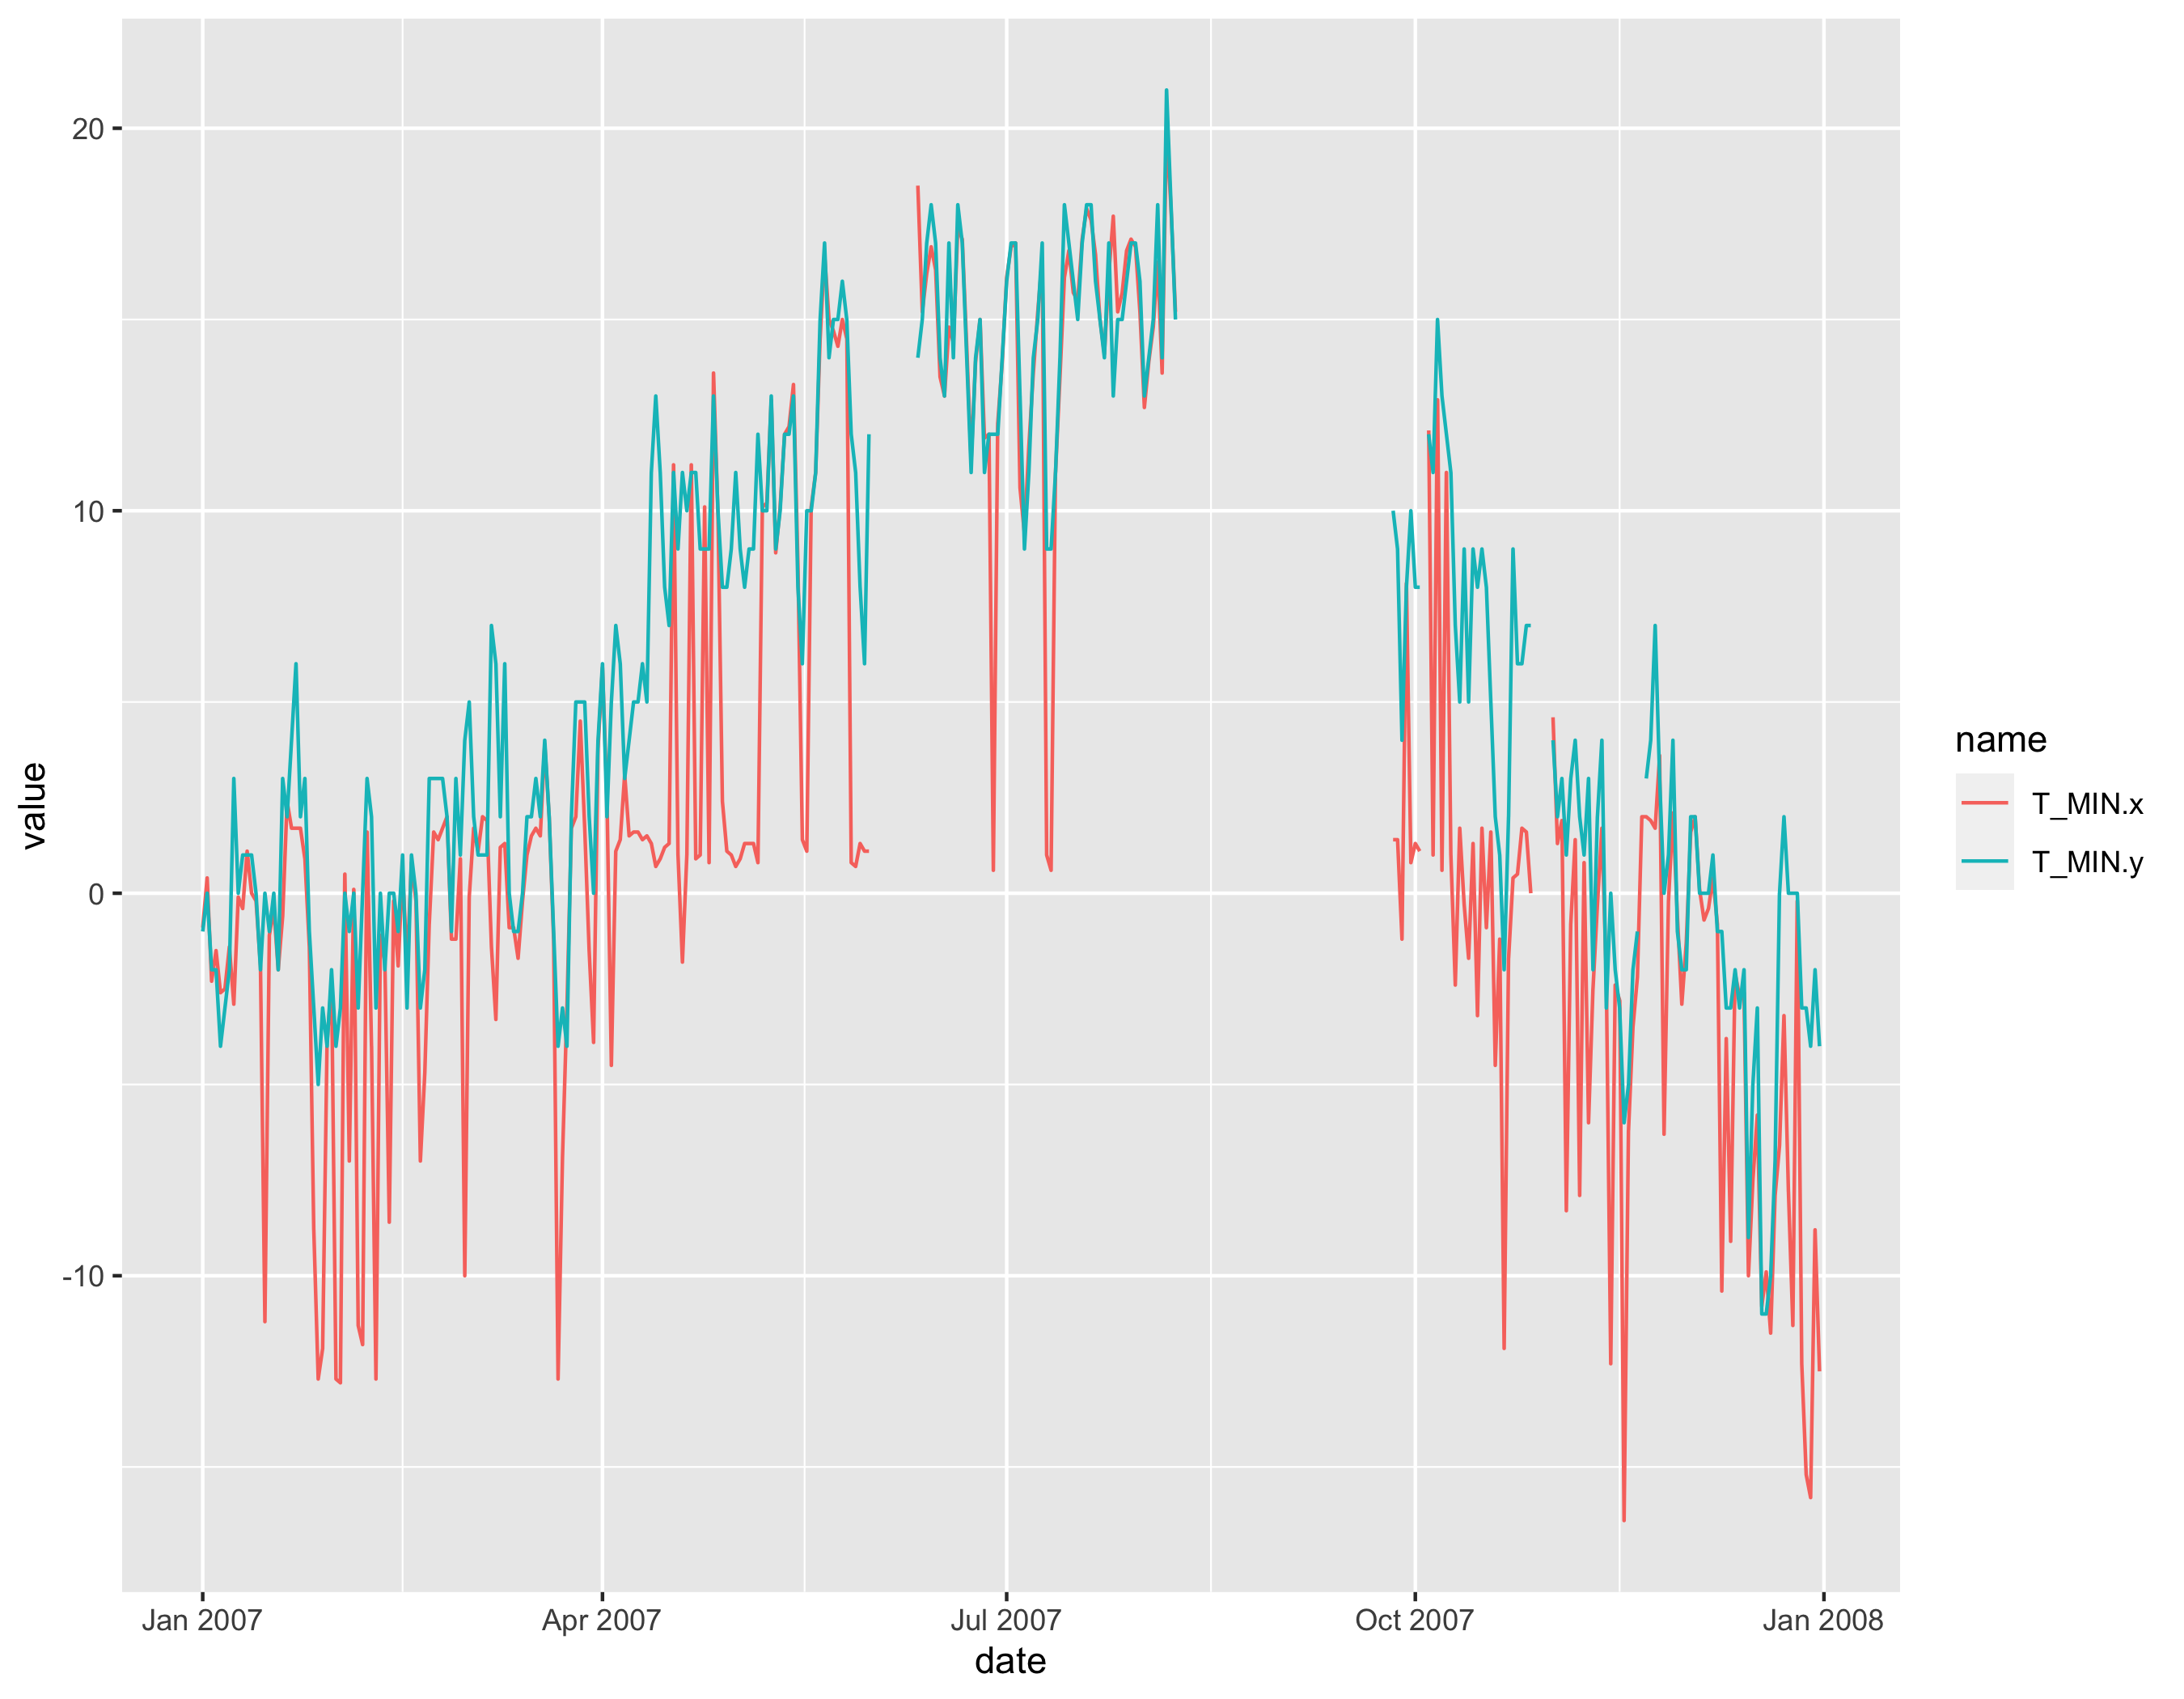

In [120]:
ab |>
    filter(2007 <= year(date), year(date) < 2008) |>
    ggplot(aes(date, value, color = name)) +
    geom_line()


In [41]:
multiple.tmin.x |> summarise(across(everything(), ~ sum(!is.na(.))))


date,6719,6863,6866,6926,6928,6929,6746,6751,6752,...,6918,6823,6824,6791,6796,6772,6817,6830,6799,6766
<date>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2000-01-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2000-01-02,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2000-01-03,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2000-01-04,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2000-01-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2000-01-06,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2000-01-07,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2000-01-08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2000-01-09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [37]:
update_left(multiple, multiple.tmin.x, multiple.tmin.y)


ERROR: Error in lm.fit(x, y, offset = offset, singular.ok = singular.ok, ...): 0 casi (non-NA)


In [231]:
preview <- open.dataset("SCIA", "data") |>
    semi_join(md.ds, by = "identifier") |>
    filter(start_date <= date, date <= stop_date) |>
    collect() |>
    as_tsibble(key = c(variable, identifier), index = date) |>
    fill_gaps(.start = start_date, .end = stop_date, .full = TRUE)


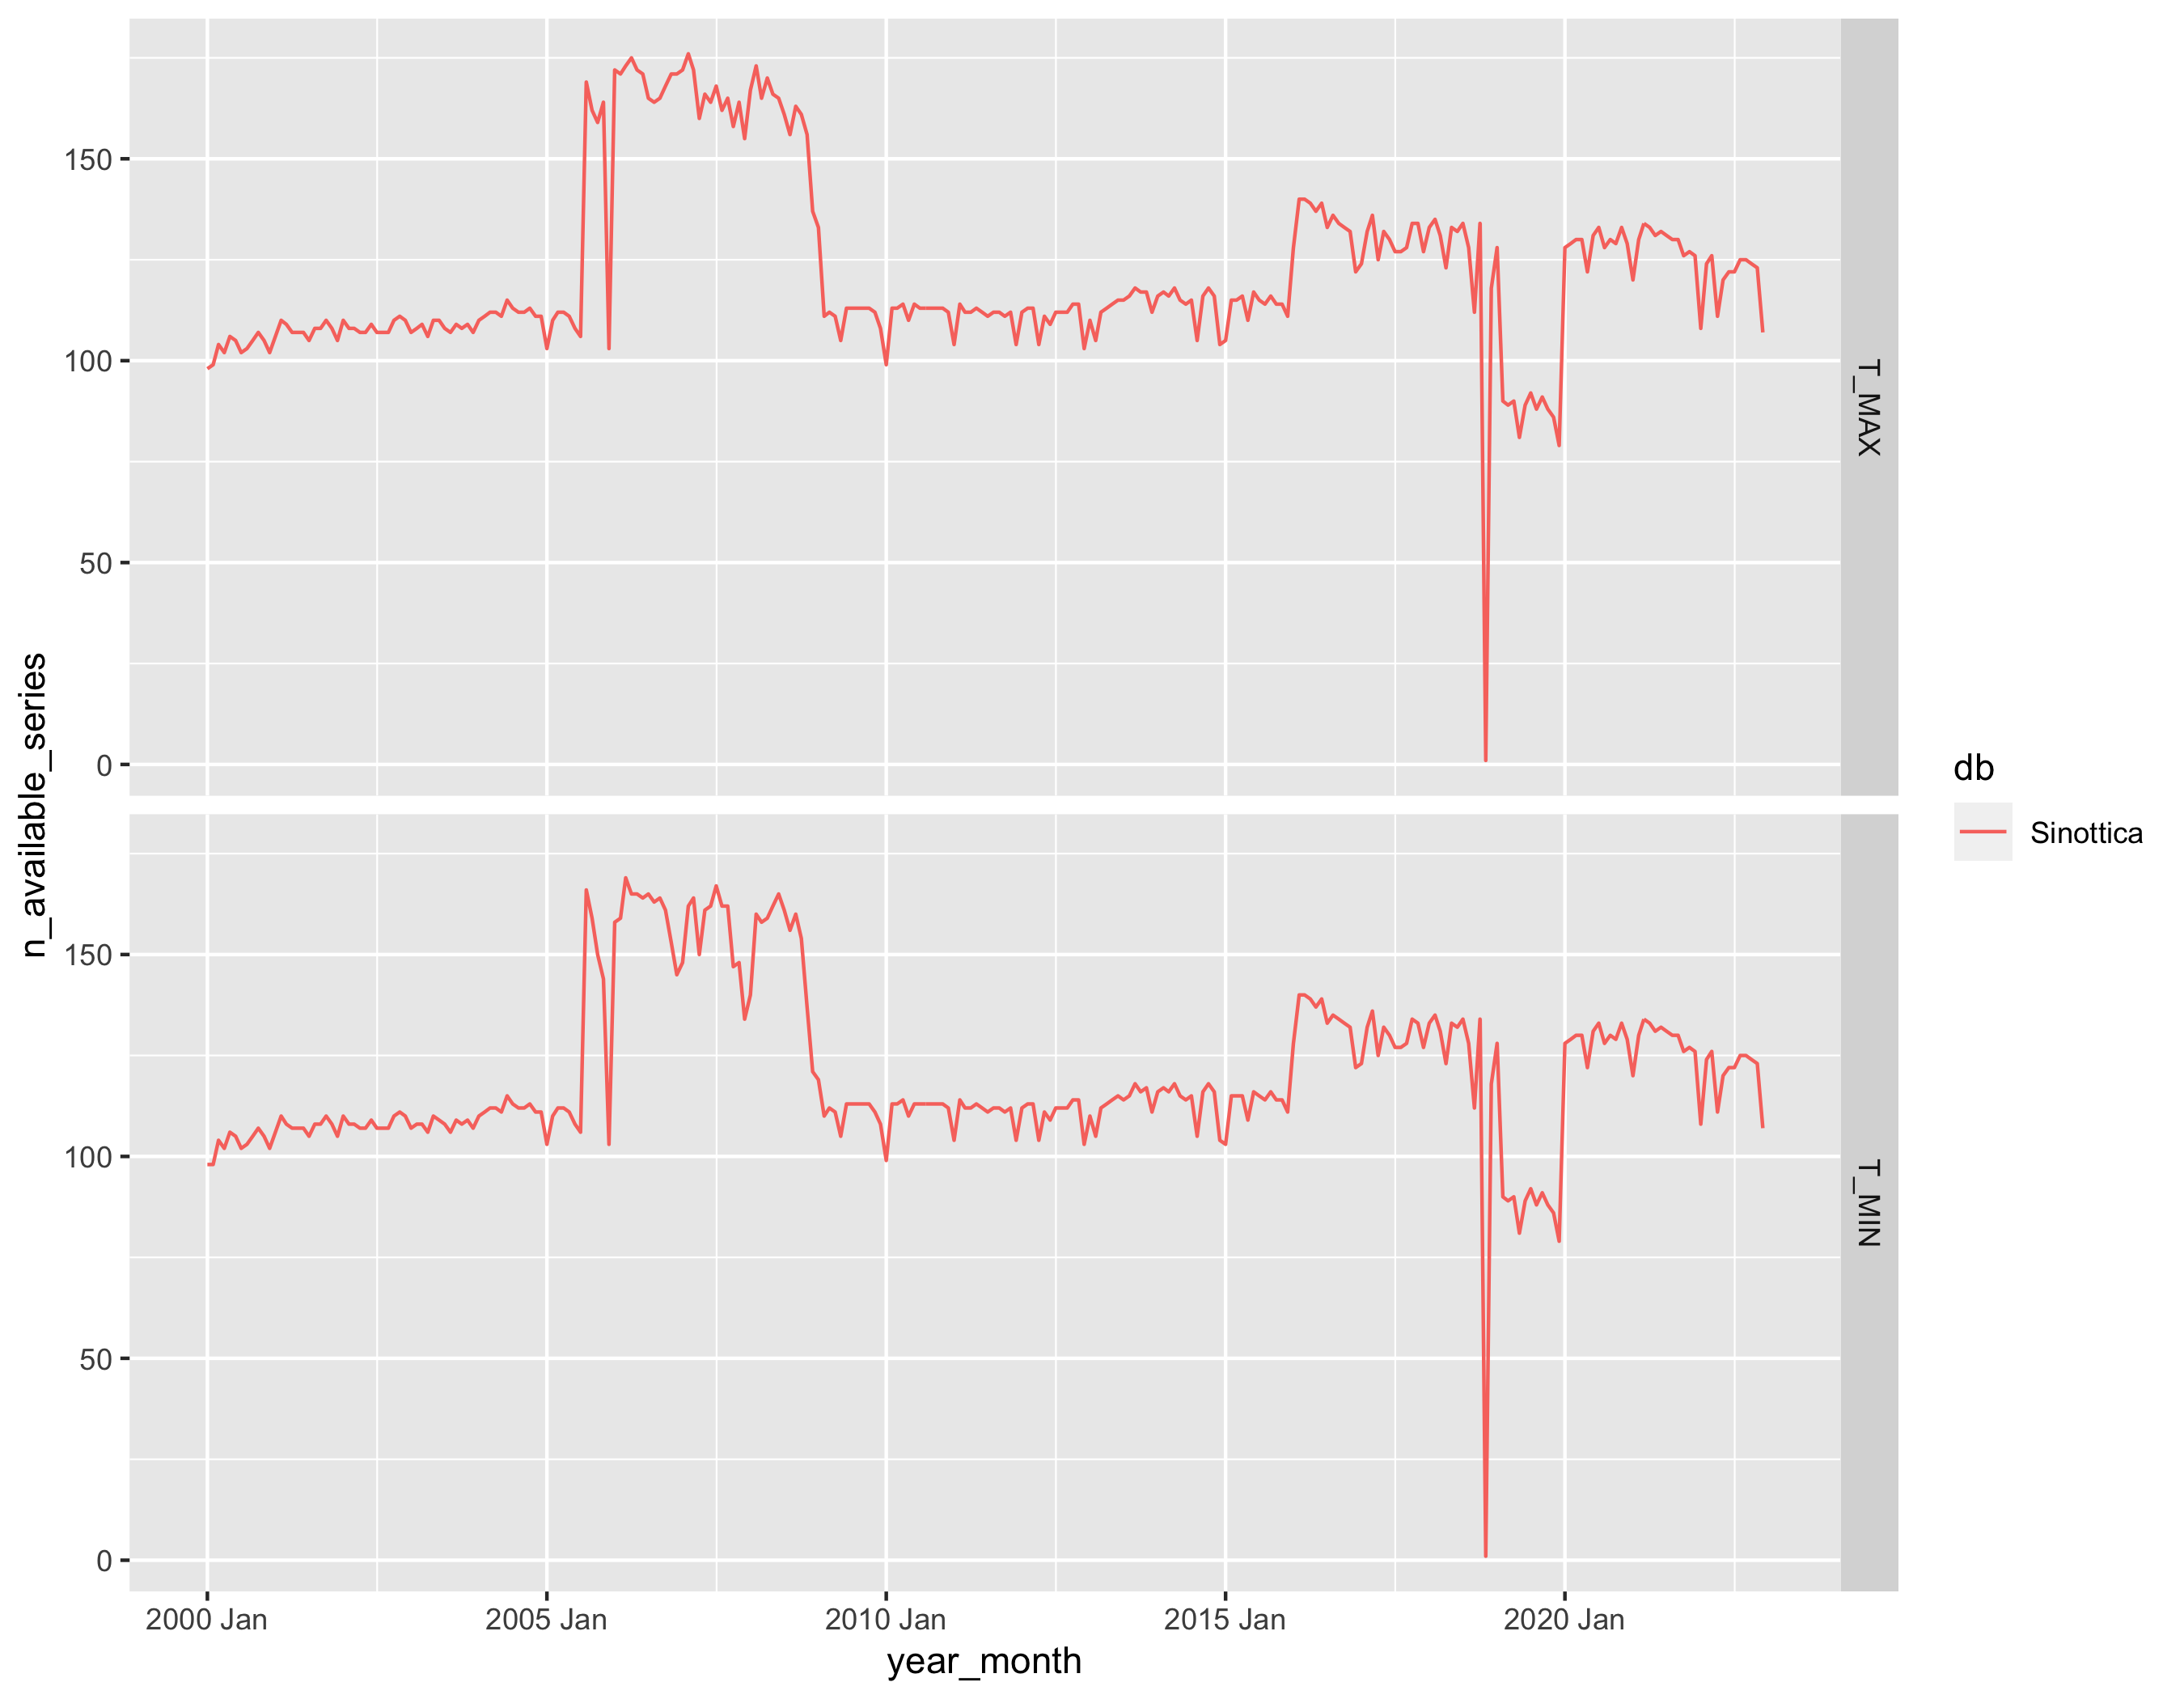

In [233]:
plot_state_avail(preview |> mutate(db = "Sinottica"))
